## CNN Feature Map Visualization

### Notebook & Packages

In [2]:
import helper as hp 
hp.initialize_notebook() # initialize with GPU enabled  
# hp.initialize_notebook(False) # to disable GPU 

2024-12-18 19:15:34.914188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 19:15:34.928753: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 19:15:34.933197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 19:15:34.944567: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU enabled. Checking for available GPUs...
1 Physical GPUs, 1 Logical GPUs

Verifying TensorFlow and PyTorch CUDA setup...
TensorFlow version: 2.17.0
Built with CUDA: True
Num GPUs Available: 1

Keras version: 3.6.0

End checks and initialization.


I0000 00:00:1734549336.973283  850776 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734549337.011869  850776 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734549337.013884  850776 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734549337.017589  850776 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
# Import standard libraries
import os
import sys
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import keras
# Import DL libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout # General Layers
from keras.layers import RandomRotation, RandomFlip
from keras import layers, models, Model, Input
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.initializers import glorot_uniform
from keras.utils import plot_model
# Suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import ML libraries
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

# Import image libraries
from skimage import transform
import tifffile as tiff
from tifffile import imread

# Appends current working dir
current_path = os.getcwd()
sys.path.append(current_path)

# Import custom preprocessing class
from imc_preprocessing import IMCPreprocessor

#### Import Data

In [4]:
images_dir = '/home/jupyter-luvogt/Final_Project_LR/IMC_images' 
metadata_dir = '/home/jupyter-luvogt/Final_Project_LR/metadata.csv'
# --- Load CSV and filter dataset ---
csv_file = metadata_dir
image_folder = images_dir

# Load the CSV
df = pd.read_csv(csv_file)

# Filter rows with NA in PDL1_score and convert to binary
df = df.dropna(subset=["PDL1_score"])
df["PDL1_score"] = df["PDL1_score"].astype(int)

# --- Train-Test-Validation Split ---
train_df, val_and_test_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df["PDL1_score"])
test_df, val_df = train_test_split(val_and_test_df, test_size=0.5, random_state=42, stratify=val_and_test_df["PDL1_score"])

# --- Load Images and Compute Mean and Standard Deviation ---

# Function to load a single image
def load_image(image_path):
    image = imread(image_path)  # Load all 46 channels
    return image.astype(np.float32)

# Initialize variables to accumulate sum and sum of squares
nr_images = 0
sum_images = np.zeros((46, 224, 224))
sum_squared_images = np.zeros((46, 224, 224))

# Accumulate the sum and sum of squares for the training dataset
for _, row in train_df.iterrows():
    image_path = os.path.join(image_folder, f"{row['sample_id']}.tiff")
    image = load_image(image_path)
    nr_images += 1
    sum_images += image
    sum_squared_images += image ** 2

# Compute mean and standard deviation
mean = sum_images / nr_images
std = np.sqrt(sum_squared_images / nr_images - mean ** 2)

# --- Dataset Loading Function ---

def load_dataset(dataframe, image_folder, normalize = True): # augment = False
    images = []
    labels = []
    
    for _, row in dataframe.iterrows():
        image_path = os.path.join(image_folder, f"{row['sample_id']}.tiff")
        image = load_image(image_path)

        if normalize:
            image = (image - mean) / std

        # Convert to channels-last format (224, 224, 46)
        image = np.transpose(image, (1, 2, 0))

        # # Apply data augmentation if specified
        # if augment:
        #     # Random horizontal flip
        #     if np.random.rand() > 0.5:
        #         image = np.flip(image, axis=2)
        #     # Random vertical flip
        #     if np.random.rand() > 0.5:
        #         image = np.flip(image, axis=1)

        images.append(image)
        labels.append(row["PDL1_score"])

    return np.array(images), np.array(labels)

### Create Datasets

In [4]:
# Training dataset without augmentation
X_train, y_train = load_dataset(train_df, image_folder, normalize = True)
# # Training dataset with data augmentation
# X_train_aug, y_train_aug = load_dataset(train_df, image_folder, augment=True)
# Validation dataset
X_val, y_val = load_dataset(val_df, image_folder, normalize = True)
# Test dataset
X_test, y_test = load_dataset(test_df, image_folder, normalize = True)

# # One Hot Encoding
# y_train= to_categorical(y_train)
# y_val= to_categorical(y_val)
# y_test = to_categorical(y_test)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (590, 224, 224, 46), y_train shape: (590,)
X_val shape: (197, 224, 224, 46), y_val shape: (197,)
X_test shape: (197, 224, 224, 46), y_test shape: (197,)


### Drop Channels

In [5]:
def drop_channels(image, channels_of_interest, channel_names):
        channel_names_new = [i for i in channel_names if i not in channels_of_interest]
        mask = np.zeros(image.shape[2], dtype=bool) # Error: np.zeros(image.shape[0], dtype=bool) and NOT np.zeros(image.shape[2], dtype=bool) (ONLY ERROR IF YOU DONT TRANSPOSE THE IMAGE, OTHERWISE OKEY)
        
        for i in channels_of_interest:
            mask[channel_names.index(i)] = True
        image = image[:, :, mask] # Error: image[mask, :, :] and not image[:, :, mask] ! (ONLY ERROR IF YOU DONT TRANSPOSE THE IMAGE, OTHERWISE OKEY)
        
        return image

In [6]:
channel_names_new = ["Gd160", "Eu153", "Gd155"]

panel_dir = '/home/jupyter-luvogt/Final_Project_LR/panel.csv' 
panel_df = pd.read_csv(panel_dir)
channel_names = dict(zip(panel_df['clean_target'].to_list(), panel_df['channel'].to_list()))

In [7]:
X_train = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_train]
X_val = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_val]
X_test = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_test]

In [8]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

### Extract last layer before classification

In [9]:
# Load Best Model
model_ResNet18 = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_biological_channels_trained.keras')

### Get Prediction for full model 

In [39]:
y_pred = model_ResNet18.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step


### Get Layer Names

In [10]:
layer_names = [layer.name for layer in model_ResNet18.layers]

We want dense2 layer to be extracted

### Get Layer Output

In [11]:
layer_outputs = [layer.output for layer in model_ResNet18.layers]

In [12]:
second_last_layer_output = layer_outputs[:-1] # Get all the layers except the last one (disgard the classification layer)

In [13]:
second_last_layer_output.reverse() # IMPORTANT: need to reverse layers apparently, otherwise it predicts the data with the model backwards

### Feature Map Model 

In [14]:
feature_map_model = Model(inputs=model_ResNet18.input, outputs=second_last_layer_output)

In [15]:
y_pred_feature_map = np.zeros(shape = (197, 512))

In [16]:
y_pred_feature_map.shape

(197, 512)

In [17]:
for i,x in enumerate(X_test): 
    x_expanded = np.expand_dims(x, axis=0) 
    pred = feature_map_model.predict(x_expanded, verbose = 0)
    y_pred_feature_map[i] = pred[0]
    gc.collect()

I0000 00:00:1734522882.386298  816850 service.cc:146] XLA service 0x7fb3cc01b030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734522882.386336  816850 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-18 11:54:42.412795: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-18 11:54:42.550217: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300
I0000 00:00:1734522884.061318  816850 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [20]:
y_pred_feature_map[0].shape

(512,)

In [19]:
feature_map_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 115, 115,  │      9,472 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 115, 115,  │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 115, 115,  │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 115, 115,  │          0 │ dropout_20[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 58, 58,    │          0 │ activation_34[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 58, 58,    │     36,928 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 58,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 58, 58,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 58, 58,    │          0 │ dropout_21[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 58, 58,    │     36,928 │ activation_35[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 58,    │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 58, 58,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 58, 58,    │          0 │ add_16[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 58, 58,    │     36,928 │ activation_36[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 58,    │        256 │ conv2d_43[0][0] 

 Total params: 15,382,144 (58.68 MB)

 Trainable params: 15,374,336 (58.65 MB)

 Non-trainable params: 7,808 (30.50 KB)

### t-SNE on output data with 3 channels

In [9]:
from sklearn.manifold import TSNE

In [22]:
tsne = TSNE(n_components=2).fit_transform(y_pred_feature_map)

In [23]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [ ]:
y_pred = (y_pred > 0.5).astype(int)

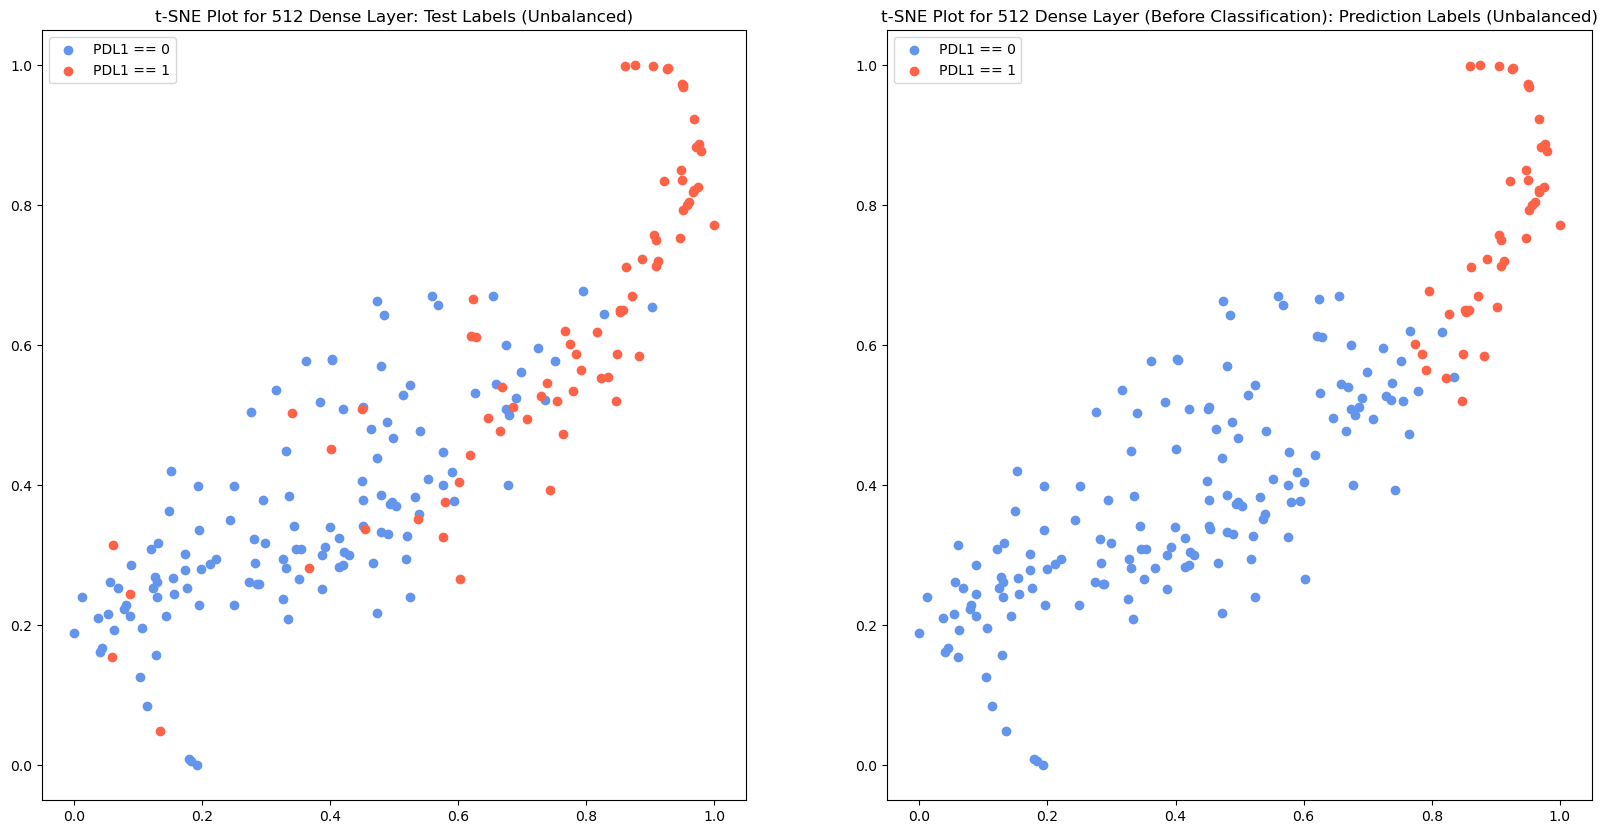

In [66]:
# initialize a matplotlib plot
fig = plt.figure(figsize = [20, 10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
colors_per_class = [0, 1]
colors = ["cornflowerblue", "tomato"]
# Plot for True Labels
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(y_test) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = colors[label]
 
    # add a scatter plot with the corresponding color and label
    ax1.scatter(current_tx, current_ty, c=color, label=label)
# Plot for predicted lables
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(y_pred) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = colors[label]
 
    # add a scatter plot with the corresponding color and label
    ax2.scatter(current_tx, current_ty, c=color, label=label)
# build a legend using the labels we set previously
ax1.legend(["PDL1 == 0", "PDL1 == 1"])
ax2.legend(["PDL1 == 0", "PDL1 == 1"])
ax1.set_title("t-SNE Plot for 512 Dense Layer: Test Labels (Unbalanced)")
ax2.set_title("t-SNE Plot for 512 Dense Layer (Before Classification): Prediction Labels (Unbalanced)")
 
# finally, show the plot
plt.show()

## t-SNE for unbalanced dataset and biological channels

In [10]:
# X_train: Define Undersampling balancing method
import imblearn
from imblearn.under_sampling import RandomUnderSampler
balancer = RandomUnderSampler(random_state = 42) # Undersampling majority class
X_test_flat = X_test.reshape(X_test.shape[0], -1) # Reshape images for balancer
X_test_resampled, y_test_resampled = balancer.fit_resample(X_test_flat, y_test) # resample (Undersampling)
X_test_resampled = X_test_resampled.reshape(-1, *X_test.shape[1:]) # Reshape the image

/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


### Model balanced dataset

In [11]:
model_ResNet18 = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_balanced_biological_channels_trained.keras')

### Get Prediction

In [26]:
y_pred_resampled = model_ResNet18.predict(X_test_resampled)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


### Get Layer Names and Layer Outputs

In [14]:
layer_names = [layer.name for layer in model_ResNet18.layers]
layer_outputs = [layer.output for layer in model_ResNet18.layers]
second_last_layer_output = layer_outputs[:-1] # Get all the layers except the last one (disgard the classification layer)
second_last_layer_output.reverse() # IMPORTANT: need to reverse layers apparently, otherwise it predicts the data with the model backwards

### Feature Map Model

In [72]:
X_test_resampled.shape

(144, 224, 224, 3)

In [21]:
feature_map_model_resampled = Model(inputs=model_ResNet18.input, outputs=second_last_layer_output)
y_pred_feature_map_resampled = np.zeros(shape = (144, 512)) # CHANGE HERE

### Predict with Feature Map Model

In [22]:
for i,x in enumerate(X_test_resampled): 
    x_expanded = np.expand_dims(x, axis=0) 
    pred = feature_map_model_resampled.predict(x_expanded, verbose = 0)
    y_pred_feature_map_resampled[i] = pred[0]
    gc.collect()

### t-SNE

In [28]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

In [29]:
tsne = TSNE(n_components=2).fit_transform(y_pred_feature_map_resampled)
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [31]:
y_pred_resampled = (y_pred_resampled > 0.5).astype(int) # To transform into 0 and 1

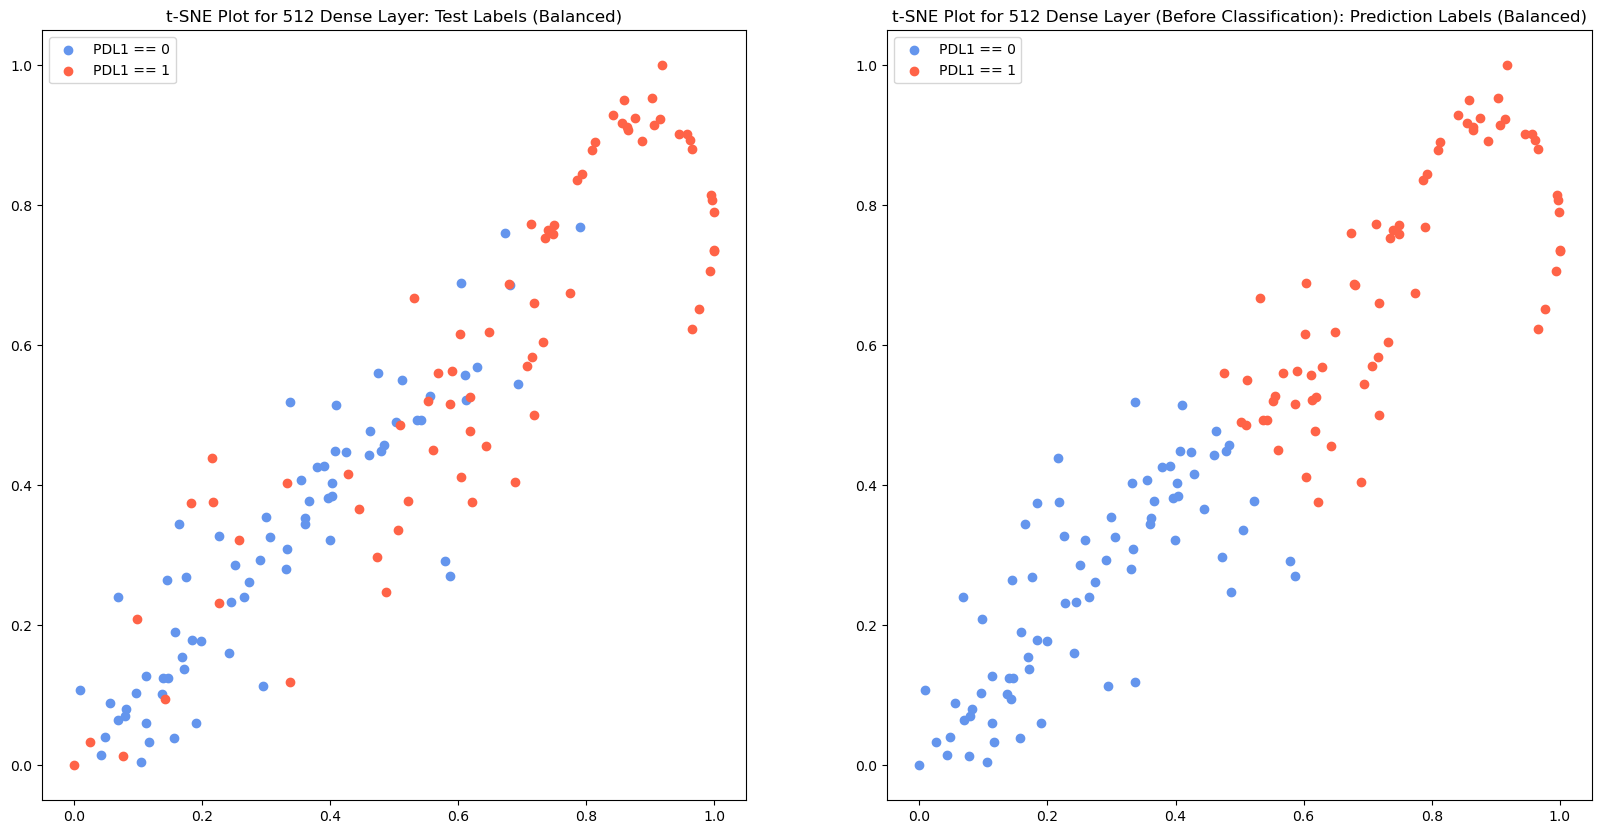

In [32]:
# initialize a matplotlib plot
fig = plt.figure(figsize = [20, 10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
colors_per_class = [0, 1]
colors = ["cornflowerblue", "tomato"]
# Plot for True Labels
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(y_test_resampled) if l == label] # CHANGE HERE
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = colors[label]
 
    # add a scatter plot with the corresponding color and label
    ax1.scatter(current_tx, current_ty, c=color, label=label)
# Plot for predicted lables
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(y_pred_resampled) if l == label] # CHANGE HERE
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = colors[label]
 
    # add a scatter plot with the corresponding color and label
    ax2.scatter(current_tx, current_ty, c=color, label=label)
# build a legend using the labels we set previously
ax1.legend(["PDL1 == 0", "PDL1 == 1"])
ax2.legend(["PDL1 == 0", "PDL1 == 1"])
ax1.set_title("t-SNE Plot for 512 Dense Layer: Test Labels (Balanced)")
ax2.set_title("t-SNE Plot for 512 Dense Layer (Before Classification): Prediction Labels (Balanced)")
 
# finally, show the plot
plt.show()

## t-SNE: with 46 channels

### Model 46 channels

In [34]:
model_ResNet18 = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_trained.keras')

In [37]:
### Create Dataset new
# Training dataset without augmentation
X_train, y_train = load_dataset(train_df, image_folder, normalize = True)
# # Training dataset with data augmentation
# X_train_aug, y_train_aug = load_dataset(train_df, image_folder, augment=True)
# Validation dataset
X_val, y_val = load_dataset(val_df, image_folder, normalize = True)
# Test dataset
X_test, y_test = load_dataset(test_df, image_folder, normalize = True)

### Get Prediction

In [38]:
y_pred = model_ResNet18.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step


### Get Layer Names and Layers Output

In [39]:
layer_names = [layer.name for layer in model_ResNet18.layers]
layer_outputs = [layer.output for layer in model_ResNet18.layers]
second_last_layer_output = layer_outputs[:-1] # Get all the layers except the last one (disgard the classification layer)
second_last_layer_output.reverse() # IMPORTANT: need to reverse layers apparently, otherwise it predicts the data with the model backwards

### Feature Map Model 

In [40]:
feature_map_model = Model(inputs=model_ResNet18.input, outputs=second_last_layer_output)
y_pred_feature_map = np.zeros(shape = (197, 512))
for i,x in enumerate(X_test): 
    x_expanded = np.expand_dims(x, axis=0) 
    pred = feature_map_model.predict(x_expanded, verbose = 0)
    y_pred_feature_map[i] = pred[0]
    gc.collect()

### t-SNE for 46 channels

In [41]:
tsne = TSNE(n_components=2).fit_transform(y_pred_feature_map)
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [42]:
y_pred = (y_pred > 0.5).astype(int)

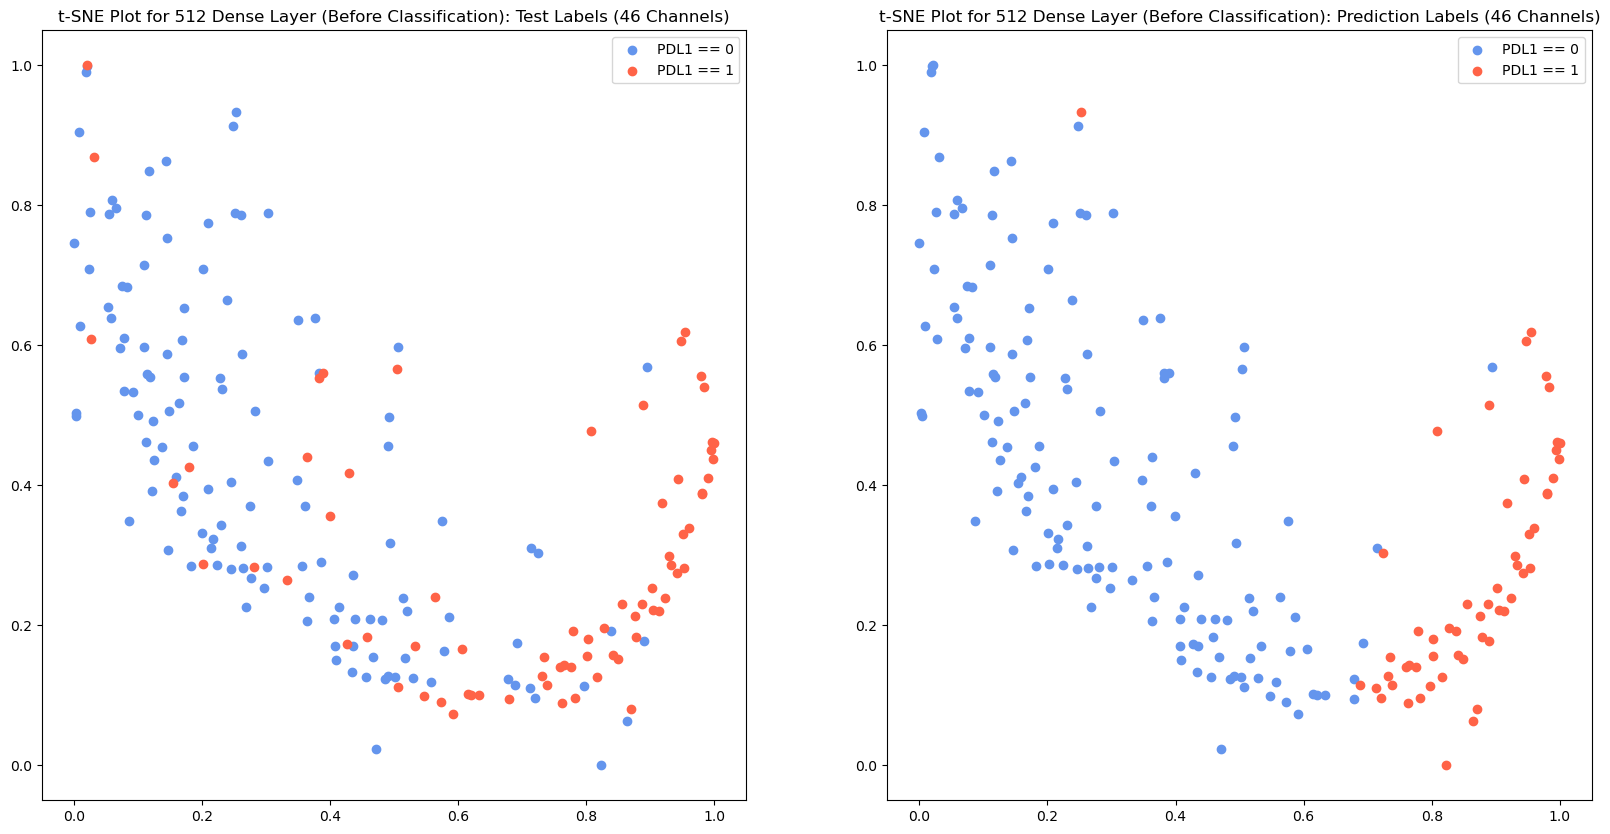

In [44]:
# initialize a matplotlib plot
fig = plt.figure(figsize = [20, 10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
colors_per_class = [0, 1]
colors = ["cornflowerblue", "tomato"]
# Plot for True Labels
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(y_test) if l == label] # CHANGE HERE
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = colors[label]
 
    # add a scatter plot with the corresponding color and label
    ax1.scatter(current_tx, current_ty, c=color, label=label)
# Plot for predicted lables
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(y_pred) if l == label] # CHANGE HERE
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = colors[label]
 
    # add a scatter plot with the corresponding color and label
    ax2.scatter(current_tx, current_ty, c=color, label=label)
# build a legend using the labels we set previously
ax1.legend(["PDL1 == 0", "PDL1 == 1"])
ax2.legend(["PDL1 == 0", "PDL1 == 1"])
ax1.set_title("t-SNE Plot for 512 Dense Layer (Before Classification): Test Labels (46 Channels)")
ax2.set_title("t-SNE Plot for 512 Dense Layer (Before Classification): Prediction Labels (46 Channels)")
 
# finally, show the plot
plt.show()

## t-SNE: 46 channels + balanced

In [5]:
model_ResNet18 = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_balanced_trained.keras')

2024-12-18 19:16:49.789435: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1578] failed to allocate 13.00GiB (13958643712 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-12-18 19:16:49.789588: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1578] failed to allocate 11.70GiB (12562779136 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-12-18 19:16:49.789694: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1578] failed to allocate 10.53GiB (11306501120 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-12-18 19:16:49.789798: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1578] failed to allocate 9.48GiB (10175850496 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-12-18 19:16:49.789901: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1578] failed to allocate 8.53GiB (9158264832 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-12-18 19:16:49.790

In [6]:
### Create Dataset new
# Training dataset without augmentation
X_train, y_train = load_dataset(train_df, image_folder, normalize = True)
# # Training dataset with data augmentation
# X_train_aug, y_train_aug = load_dataset(train_df, image_folder, augment=True)
# Validation dataset
X_val, y_val = load_dataset(val_df, image_folder, normalize = True)
# Test dataset
X_test, y_test = load_dataset(test_df, image_folder, normalize = True)

In [7]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

# X_train: Define Undersampling balancing method
balancer = RandomUnderSampler(random_state = 42) # Undersampling majority class
X_train_flat = X_train.reshape(X_train.shape[0], -1) # Reshape images for balancer
X_train_resampled, y_train_resampled = balancer.fit_resample(X_train_flat, y_train) # resample (Undersampling)
X_train_resampled = X_train_resampled.reshape(-1, *X_train.shape[1:]) # Reshape the image

# X_val: Define Undersampling balancing method
balancer = RandomUnderSampler(random_state = 42) # Undersampling majority class
X_val_flat = X_val.reshape(X_val.shape[0], -1) # Reshape images for balancer
X_val_resampled, y_val_resampled = balancer.fit_resample(X_val_flat, y_val) # resample (Undersampling)
X_val_resampled = X_val_resampled.reshape(-1, *X_val.shape[1:]) # Reshape the image

X_test_flat = X_test.reshape(X_test.shape[0], -1) # Reshape images for balancer
X_test_resampled, y_test_resampled = balancer.fit_resample(X_test_flat, y_test) # resample (Undersampling)
X_test_resampled = X_test_resampled.reshape(-1, *X_test.shape[1:]) # Reshape the image

/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/bas

### Get Prediction

In [8]:
y_pred = model_ResNet18.predict(X_test)

2024-12-18 19:19:01.909489: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1818779648 exceeds 10% of free system memory.
2024-12-18 19:19:02.960111: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1818779648 exceeds 10% of free system memory.
I0000 00:00:1734549546.548020  850873 service.cc:146] XLA service 0x7ff69d01c520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734549546.548243  850873 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-18 19:19:07.751482: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-18 19:19:09.658937: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300


3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

I0000 00:00:1734549563.905822  850873 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 473ms/step


### Get Names and Outputs

In [9]:
layer_names = [layer.name for layer in model_ResNet18.layers]
layer_outputs = [layer.output for layer in model_ResNet18.layers]
second_last_layer_output = layer_outputs[:-1] # Get all the layers except the last one (disgard the classification layer)
second_last_layer_output.reverse() # IMPORTANT: need to reverse layers apparently, otherwise it predicts the data with the model backwards

### Feature Map Model 

In [10]:
feature_map_model = Model(inputs=model_ResNet18.input, outputs=second_last_layer_output)
y_pred_feature_map = np.zeros(shape = (197, 512))
for i,x in enumerate(X_test): 
    x_expanded = np.expand_dims(x, axis=0) 
    pred = feature_map_model.predict(x_expanded, verbose = 0)
    y_pred_feature_map[i] = pred[0]
    gc.collect()

### t-SNE: 46 Channels + Balanced

In [12]:
from sklearn.manifold import TSNE

In [14]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
tsne = TSNE(n_components=2).fit_transform(y_pred_feature_map)
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
y_pred = (y_pred > 0.5).astype(int)

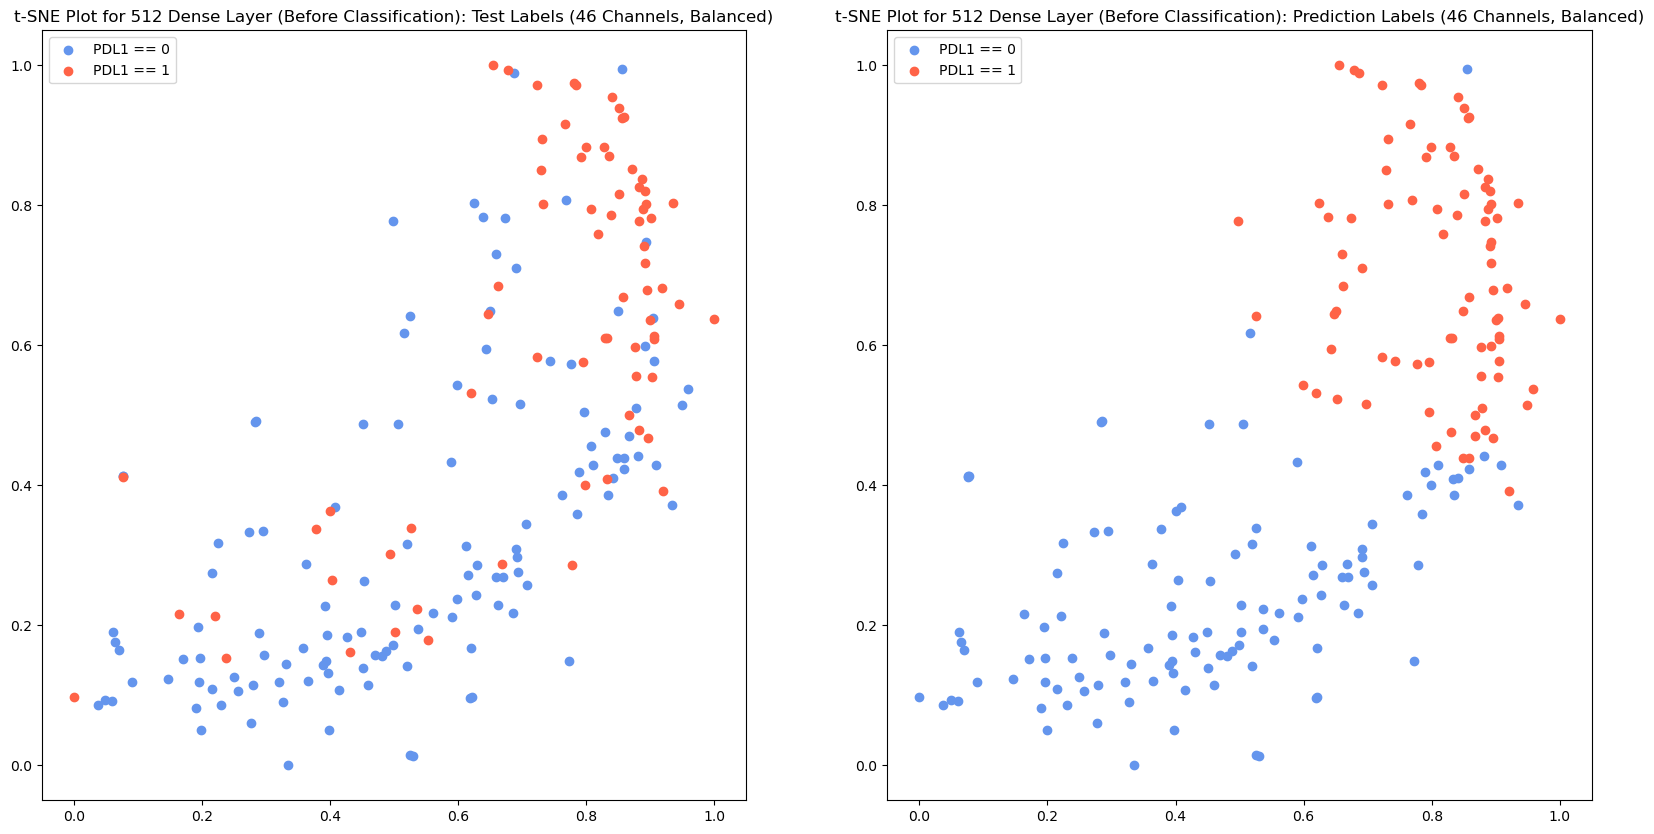

In [15]:
# initialize a matplotlib plot
fig = plt.figure(figsize = [20, 10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
colors_per_class = [0, 1]
colors = ["cornflowerblue", "tomato"]
# Plot for True Labels
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(y_test) if l == label] # CHANGE HERE
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = colors[label]
 
    # add a scatter plot with the corresponding color and label
    ax1.scatter(current_tx, current_ty, c=color, label=label)
# Plot for predicted lables
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(y_pred) if l == label] # CHANGE HERE
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = colors[label]
 
    # add a scatter plot with the corresponding color and label
    ax2.scatter(current_tx, current_ty, c=color, label=label)
# build a legend using the labels we set previously
ax1.legend(["PDL1 == 0", "PDL1 == 1"])
ax2.legend(["PDL1 == 0", "PDL1 == 1"])
ax1.set_title("t-SNE Plot for 512 Dense Layer (Before Classification): Test Labels (46 Channels, Balanced)")
ax2.set_title("t-SNE Plot for 512 Dense Layer (Before Classification): Prediction Labels (46 Channels, Balanced)")
 
# finally, show the plot
plt.show()

In [16]:
!pip install visualkeras

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 2.0 MB/s eta 0:00:00ta 0:00:01


In [17]:
import visualkeras
from PIL import ImageFont

/home/jupyter-luvogt/.local/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


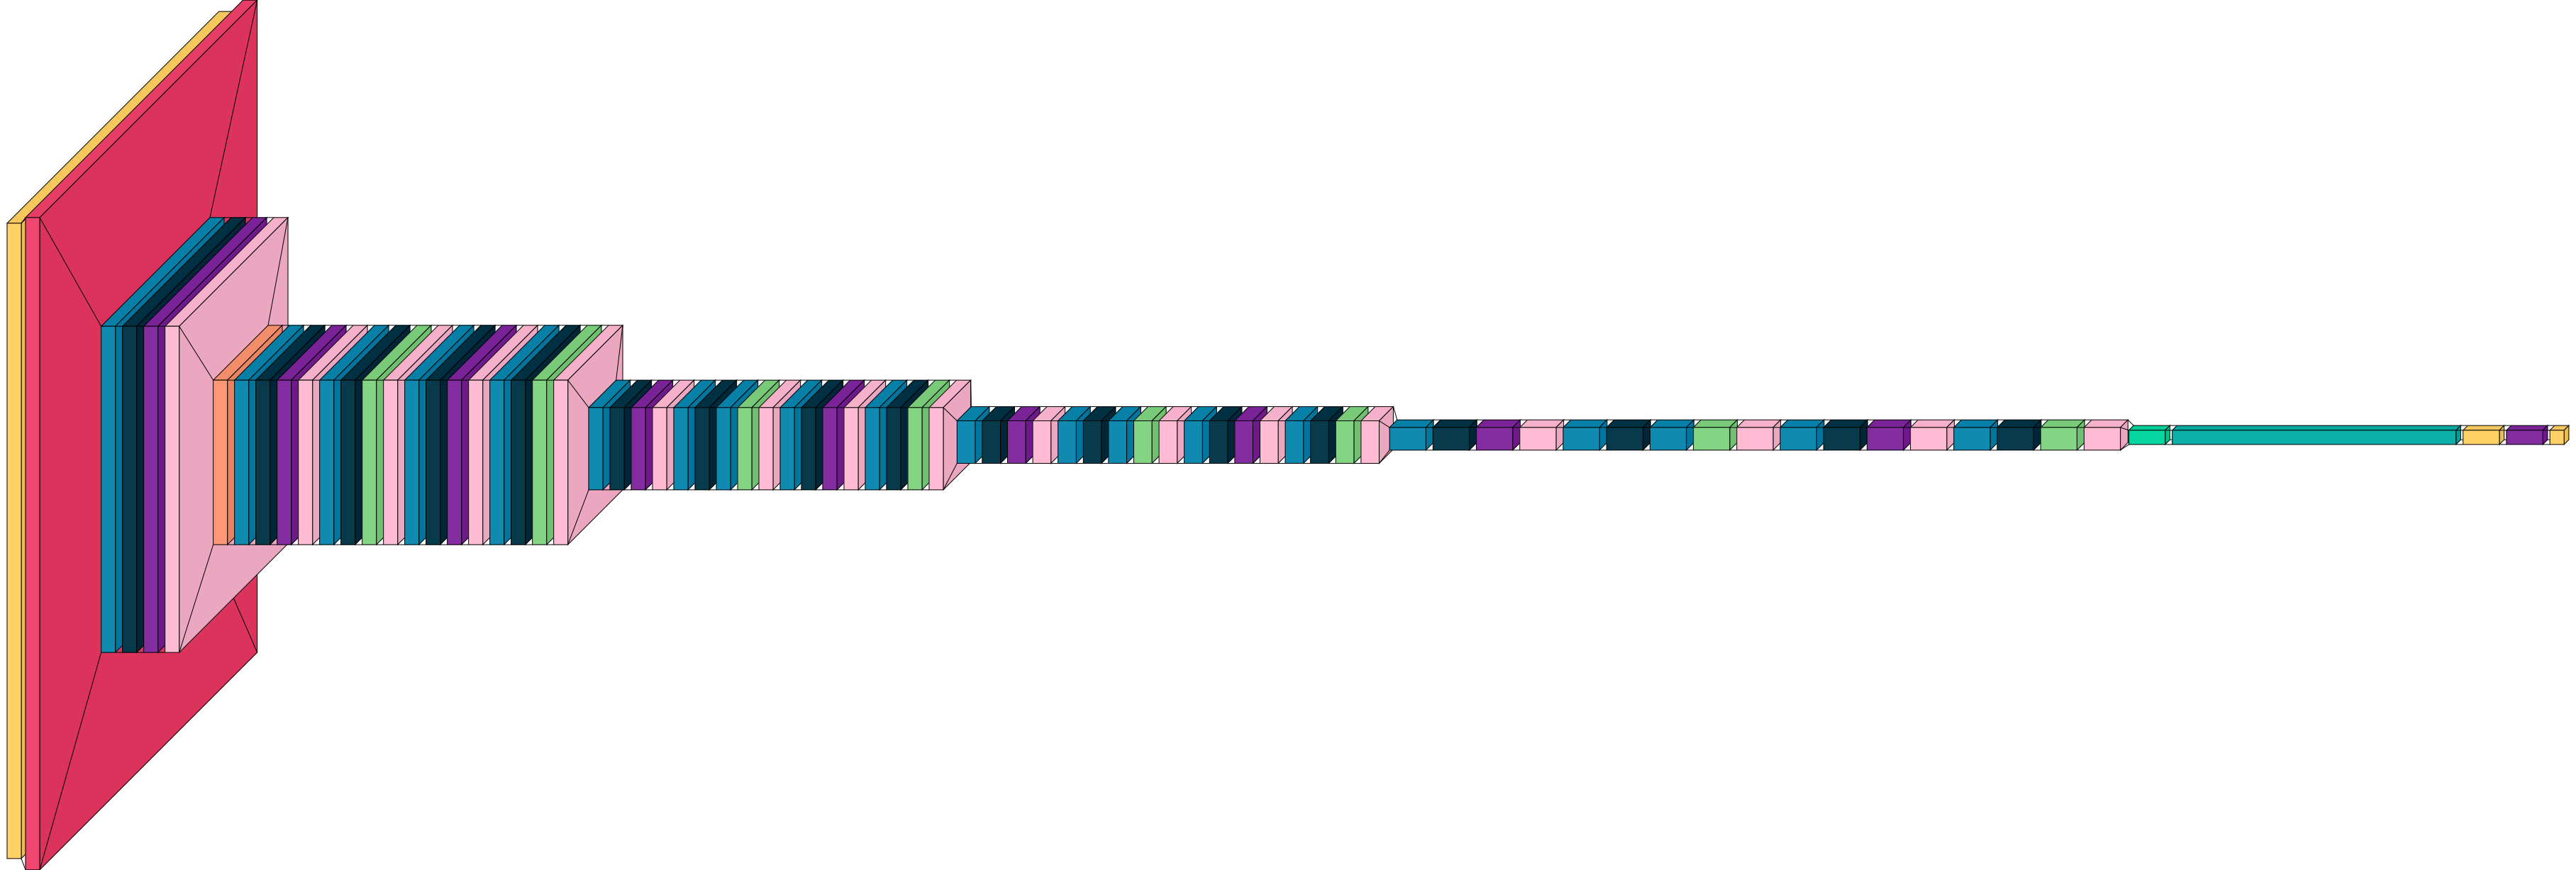

In [18]:
visualkeras.layered_view(model_ResNet18)

In [19]:
from PIL import ImageFont

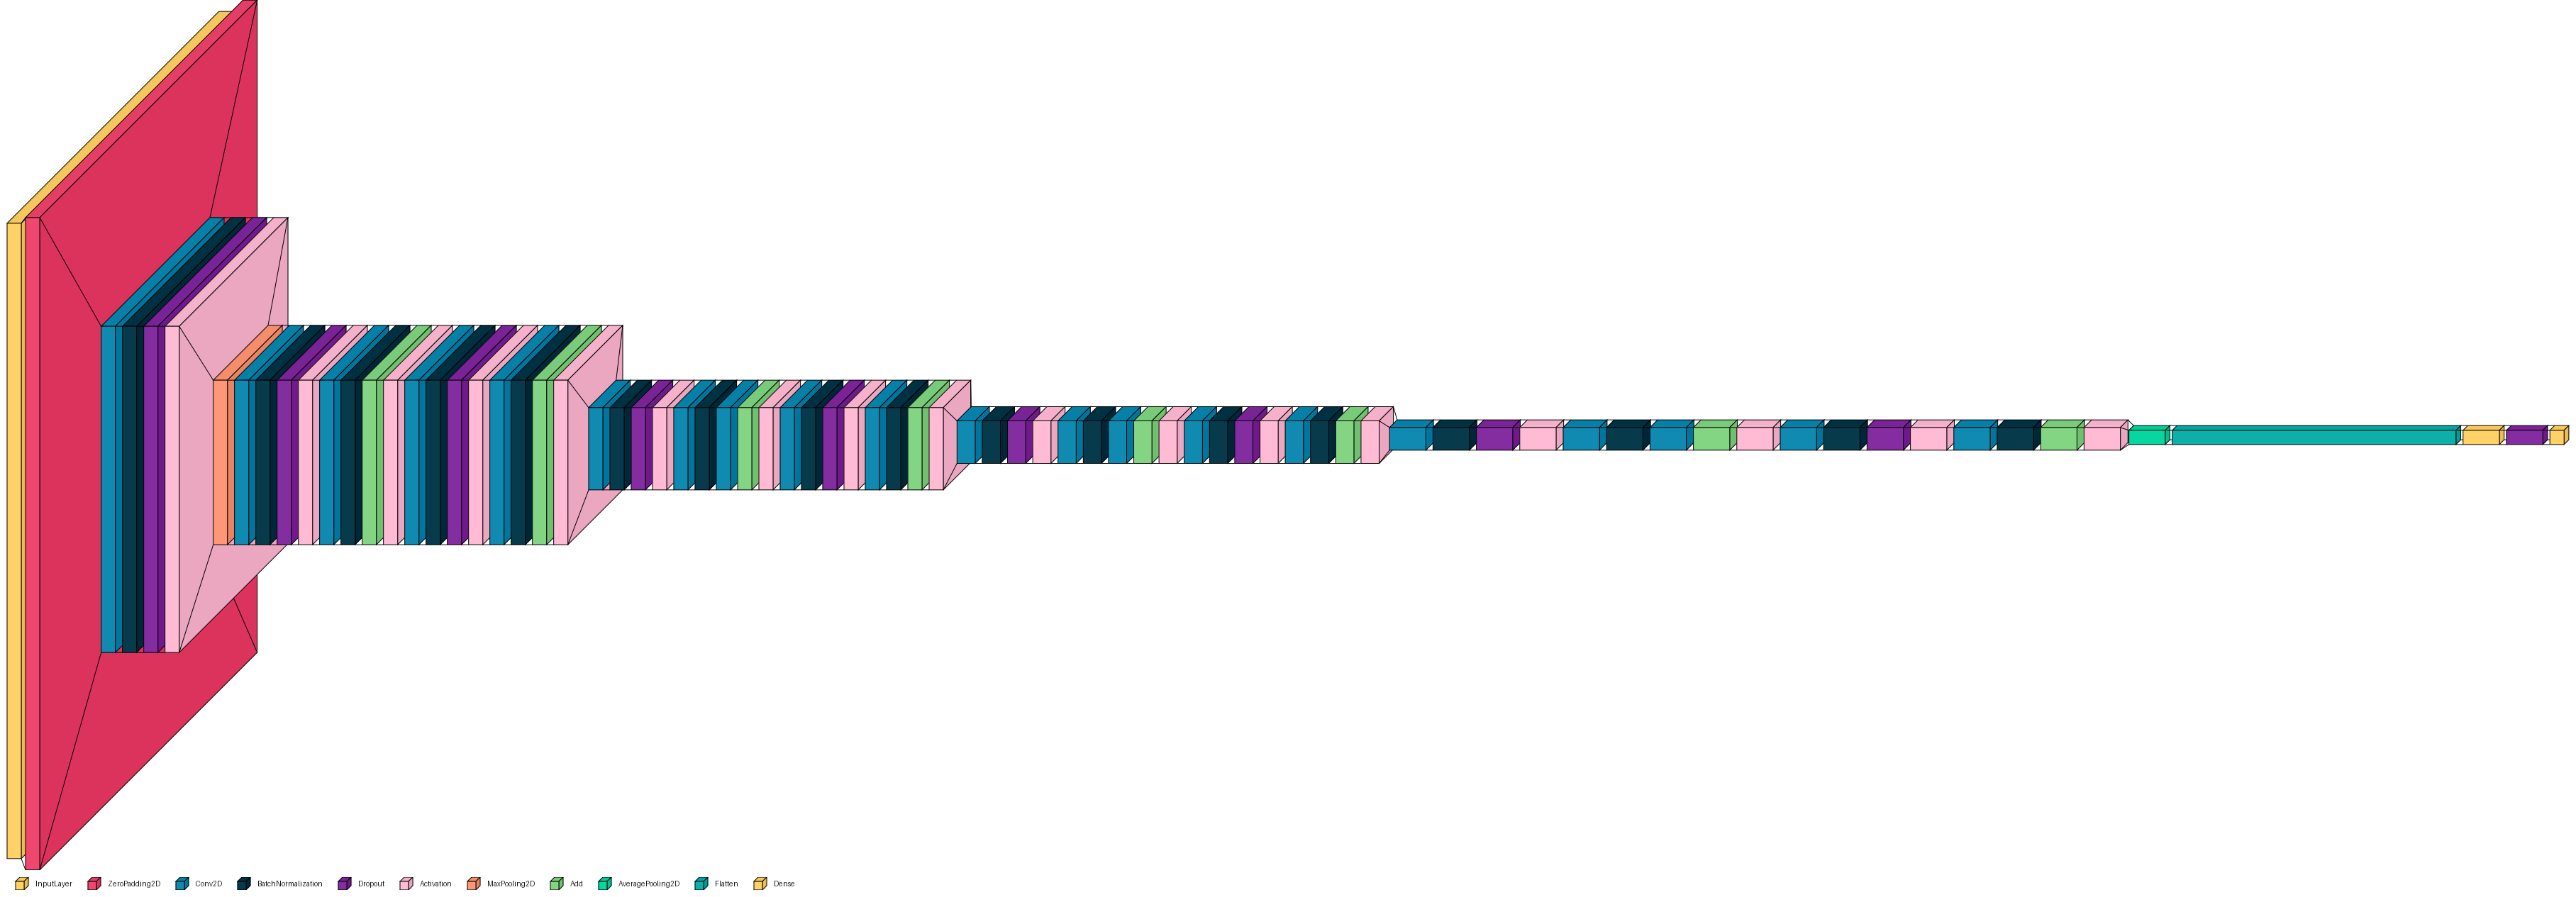

In [25]:
visualkeras.layered_view(model_ResNet18, legend=True) # selected font

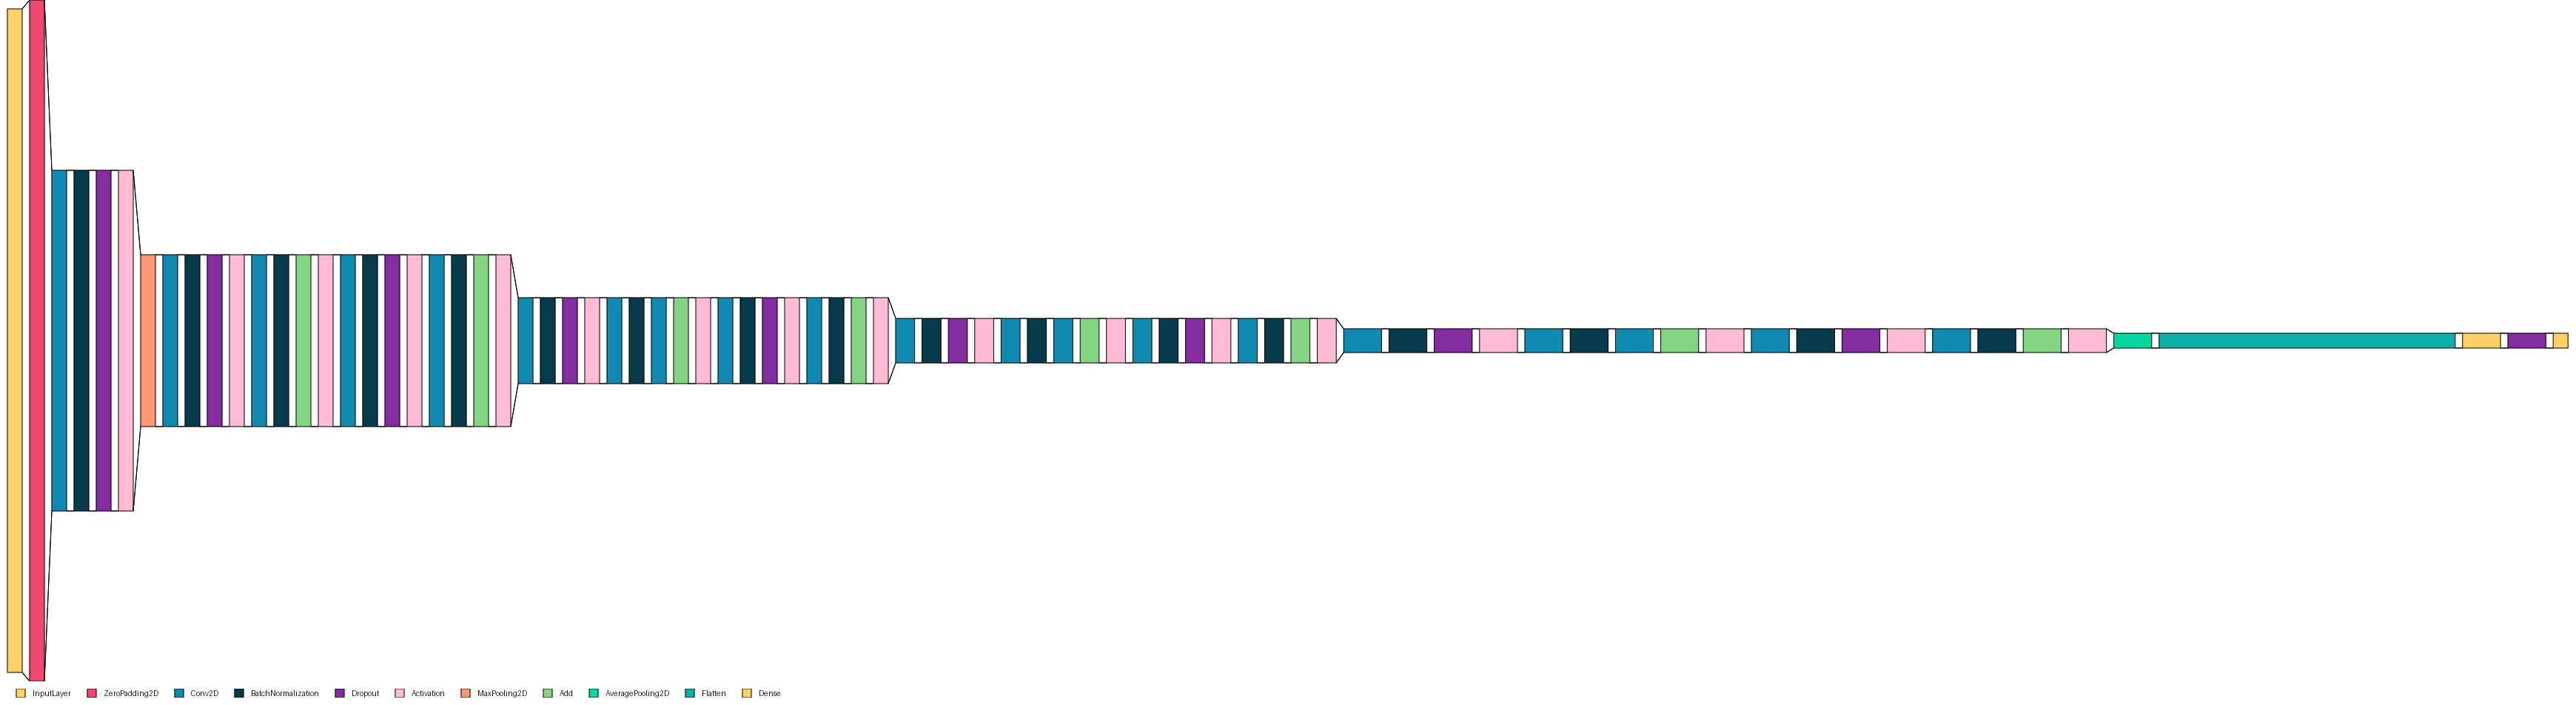

In [34]:
visualkeras.layered_view(model_ResNet18, legend=True, spacing = 10, draw_volume = False) # selected font